In [16]:
import netket as nk
import json
from qutip import *
import numpy as np
import time
import multiprocessing as mp
from collections import OrderedDict
from pickle import dump
import os
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
from functools import reduce
plt.style.use('seaborn')
from scipy.stats import norm
import sys
sys.path.append("/home/victor1/penalty_method")
import expect_grad_ex
import vmc_ex
import jax
import optax

from typing import Callable, Optional
from functools import partial

import jax
import jax.numpy as jnp

from netket.utils.types import PyTree, Array
import netket.jax as nkjax

from netket.vqs.mc import (
    kernels,
    check_hilbert,
    get_local_kernel_arguments,
    get_local_kernel,
)

from netket.vqs.mc.mc_state.state import MCState

from netket.operator import (
    AbstractOperator,
    DiscreteOperator,
    Squared,
    ContinuousOperator,
)

from netket.vqs.mc import (
    get_local_kernel_arguments,
    get_local_kernel,
)
from netket.stats import Stats, statistics
import matplotlib
matplotlib.rcParams["figure.dpi"] = 100
plt.rcParams['text.usetex'] = True

In [17]:
n_samples_global = 500000
#we define necessary functions here
def batch_discrete_kernel(kernel):
    """
    Batch a kernel that only works with 1 sample so that it works with a
    batch of samples.
    Works only for discrete-kernels who take two args as inputs
    """

    def vmapped_kernel(logpsi_1, logpsi_2, pars1, pars2, σ, args):
        """
        local_value kernel for MCState and generic operators
        """
        σp, mels = args

        if jnp.ndim(σp) != 3:
            σp = σp.reshape((σ.shape[0], -1, σ.shape[-1]))
            mels = mels.reshape(σp.shape[:-1])

        vkernel = jax.vmap(kernel, in_axes=(None, None,None,None, 0, (0, 0)), out_axes=0)
        return vkernel(logpsi_1, logpsi_2, pars1, pars2, σ, (σp, mels))

    return vmapped_kernel

#we first need to estabalish the kernel functions for evaluating expectation values
@partial(jax.jit, static_argnums=(0, 1))
@batch_discrete_kernel
def corr_kernel(logpsi_1: Callable, logpsi_2: Callable, pars1: PyTree, pars2: PyTree, σ: Array, args: PyTree):
    σp, mel = args


    return jnp.sum(mel * jnp.exp(logpsi_1(pars1, σp) - logpsi_2(pars2, σ)))


def get_local_kernel_arguments(vstate: MCState, Ô: DiscreteOperator):  # noqa: F811
    check_hilbert(vstate.hilbert, Ô.hilbert)

    σ = vstate.samples
    σp, mels = Ô.get_conn_padded(σ)
    
    return σ, (σp, mels)

In [18]:
#here is the function for expectation value
#input: operator, left_psi (rbm object, parameter finalized), right_psi (rbm object, parameter finalized)
def expect(operator, left_psi, right_psi):
    para1 = right_psi.parameters
    para2 = left_psi.parameters
    
    logpsi_1 = right_psi._apply_fun
    logpsi_2 = left_psi._apply_fun
    
    model_state1 = right_psi.model_state
    model_state2 = left_psi.model_state
    
    σ, args = get_local_kernel_arguments(left_psi, operator)

    σ_shape = σ.shape
    if jnp.ndim(σ) != 2:
        σ = σ.reshape((-1, σ_shape[-1]))

    psi_loc = corr_kernel(
            logpsi_1,
            logpsi_2,
            {"params": para1, **model_state1},
            {"params": para2, **model_state2},
            σ,
            args,
        )

    psi = statistics(psi_loc)

    return psi.mean

In [19]:
def corr_test(t_obver, obver, sta_list, eng_list, n_samples):

    initial_list = []
    
    #re-set the number of samples
    for ii in range(len(eng_list)):
        sta_list[ii].reset()
        sta_list[ii].n_samples = n_samples
    
    for j in range(len(eng_list)):
        np.random.seed()
        initial_list.append(expect(t_obver, sta_list[0], sta_list[j]) * expect(obver, sta_list[j], sta_list[0]))

    return sum(initial_list)

In [20]:
#below are standard functions we need for model setup
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()
    

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace

def exactDiagonalization_full(hamiltonian):
    # Changes Hamiltonian to matrix form
    haMatrix = hamiltonian.to_dense()
    # Gets eigenvalues and vectors
    eigenValues, v = np.linalg.eigh(haMatrix)
    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

def state_error(state_list, ex_state_list, N):
    state_er = []
    for i in range(len(state_list)):
        state_er_temp = err_sta(state_list[i], ex_state_list[i], N)
        state_er.append(state_er_temp)
    return state_er

# Error Calculation (Input: the found state, the state from exact diagonalization, the found energy, the energy from exact diagonalization)
def err_sta(state, edState,N):
    overlap = np.dot(state.conj().reshape(2**N, 1).T, edState.reshape(2**N, 1))
    waveFunctionErr = 1 - (np.linalg.norm(overlap))**2
    return waveFunctionErr

def eng_error(eng_list, ex_energy):
    eng_er = []
    for i in range(len(eng_list)):
        eng_er_temp = np.abs(eng_list[i] - ex_energy[i])
        eng_er.append(eng_er_temp)
    return eng_er

In [21]:
#now let's do some dynamics
N = 6
Ak = []

alpha = 1   #density of RBM
M = alpha*N
# Constant A
B = 0.95
# Variable A
A = N/2
N0 = N/2
for i in range(N-1):
    # Constant A
    #Ak_i = 1
    # Variable A
    Ak_i = A / (N0) * np.exp(-i / N0)
    Ak.append(Ak_i)
    
# Define hamiltonian and hilbert space
ha, hi = CSHam(N,B,Ak)


#Exact Diagonalization
e, v = exactDiagonalization_full(ha)

In [22]:
#we now need to create the plus and minus operator in netket local operator format
g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
# Spin based Hilbert Space
hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
# Define spin operators with \hbar set to 1
sz = 0.5 * np.array([[1, 0], [0, -1]])
sx = 0.5 * np.array([[0, 1], [1, 0]])
sy = 0.5 * np.array([[0, -1j], [1j, 0]])
operators_p = []
operators_m = []
sites_p = []
sites_m = []

# plus operator
operators_p.append((sx + 1j * sy).tolist()) #array to list(ordered and changeable)
sites_p.append([0])
# Create plus operator
S_plus = nk.operator.LocalOperator(hilbertSpace, operators=operators_p, acting_on=sites_p, dtype=complex)

# minus operator
operators_m.append((sx - 1j * sy).tolist()) #array to list(ordered and changeable)
sites_m.append([0])
# Create plus operator
S_minus = nk.operator.LocalOperator(hilbertSpace, operators=operators_m, acting_on=sites_m, dtype=complex)

In [23]:
#now we need the inexact eigenstates in rbm representation
#we need to load the parameters first, then create a list of eigenstates
#this shit loads the ground state parameters
import pickle
fileName_0 = "eigenstate_data/parameter_N6i0j38_best-Copy1.json"
file_0 = open(fileName_0,'rb')
a0 = pickle.load(file_0)

fileName_1 = "eigenstate_data/parameter_N6i1j41_best-Copy1.json"
file_1 = open(fileName_1,'rb')
a1 = pickle.load(file_1)

fileName_2 = "eigenstate_data/parameter_N6i2j22_best-Copy1.json"
file_2 = open(fileName_2,'rb')
a2 = pickle.load(file_2)

fileName_3 = "eigenstate_data/parameter_N6i3j10_best-Copy1.json"
file_3 = open(fileName_3,'rb')
a3 = pickle.load(file_3)

n_samples = n_samples_global
alpha = 1
ma = nk.models.RBM(alpha=alpha, dtype=complex,use_visible_bias=True, use_hidden_bias=True)
sampler = nk.sampler.MetropolisLocal(hilbert=hi)

vs_0 = nk.vqs.MCState(sampler, ma, n_samples=n_samples, n_discard_per_chain=n_samples/10)
vs_0.parameters = a0
eng_0 = np.real(vs_0.expect(ha).mean)
vs_1 = nk.vqs.MCState(sampler, ma, n_samples=n_samples, n_discard_per_chain=n_samples/10)
vs_1.parameters = a1
eng_1 = np.real(vs_1.expect(ha).mean)
vs_2 = nk.vqs.MCState(sampler, ma, n_samples=n_samples, n_discard_per_chain=n_samples/10)
vs_2.parameters = a2
eng_2 = np.real(vs_2.expect(ha).mean)
vs_3 = nk.vqs.MCState(sampler, ma, n_samples=n_samples, n_discard_per_chain=n_samples/10)
vs_3.parameters = a3
eng_3 = np.real(vs_3.expect(ha).mean)

state_list = [vs_0, vs_1, vs_2, vs_3]
eng_list = [eng_0, eng_1, eng_2, eng_3]

In [24]:

numRuns = 200

values = []
for i in range(200):
    values.append(corr_test(S_plus, S_minus, state_list, eng_list, n_samples_global))
    print(i)
'''
hisIt = np.arange(numRuns)

# Cluster multiproccessing
ncpus = int(os.environ.get('SLURM_CPUS_PER_TASK',default=20))
pool = mp.Pool(processes=ncpus)
# Run Descent
results = []
for j in hisIt:
    result = pool.apply_async(corr_test, args=(S_plus, S_minus, state_list, eng_list, n_samples_global)) 
    results.append(result)
    
pool.close()
pool.join()
#values = [r.get() for r in results]


fileName = "2022_data/correlation_data/corr_hist"+str(N)+"M" + str(M)+".json"
open(fileName, "w").close()
with open(fileName, 'a') as file:
    line = json.dumps(results)
    file.write(line)
print('SAVED')
'''

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


'\nhisIt = np.arange(numRuns)\n\n# Cluster multiproccessing\nncpus = int(os.environ.get(\'SLURM_CPUS_PER_TASK\',default=20))\npool = mp.Pool(processes=ncpus)\n# Run Descent\nresults = []\nfor j in hisIt:\n    result = pool.apply_async(corr_test, args=(S_plus, S_minus, state_list, eng_list, n_samples_global)) \n    results.append(result)\n    \npool.close()\npool.join()\n#values = [r.get() for r in results]\n\n\nfileName = "2022_data/correlation_data/corr_hist"+str(N)+"M" + str(M)+".json"\nopen(fileName, "w").close()\nwith open(fileName, \'a\') as file:\n    line = json.dumps(results)\n    file.write(line)\nprint(\'SAVED\')\n'

In [29]:
print(np.std(np.real(values), ddof=1))
values = np.array(np.real(values)).tolist()
fileName = "2022_data/correlation_data/corr_hist"+str(N)+"M" + str(M)+".json"
open(fileName, "w").close()
with open(fileName, 'a') as file:
    line = json.dumps(values)
    file.write(line)
print('SAVED')

0.00555819741669604
SAVED


In [31]:
#let's get the exact value
dense_sta = []
for i in range(len(state_list)):
    dense_sta.append(state_list[i].to_array())


def expected_2(A, bra, ket):
        
    expectation = np.dot(np.conj(bra).T, np.matmul(A, ket) )
    return expectation

#evolve correlation function
def dense_corr_test(t_obver, obver, sta_list, eng_list, N):

    sumed = 0.0
    for j in range(len(eng_list)):
        sumed += expected_2(t_obver, sta_list[0], sta_list[j]) * expected_2(obver, sta_list[j], sta_list[0])
        
            
    return sumed

#construct the S+0 and S-0 operators of interest
def S0_p(N):
    S0_p = []
    si = qeye(2)
    op_list = []
    for m in range(N):     
        op_list.append(si)
    op_list[0] = sigmap()
    S0_p.append(tensor(op_list))
    
    return S0_p[0]

def S0_m(N):
    S0_m = []
    si = qeye(2)
    op_list = []
    for m in range(N):     
        op_list.append(si)
    op_list[0] = sigmam()
    S0_m.append(tensor(op_list))
    
    return S0_m[0]

obver_p = np.array(S0_p(N))
obver_m = np.array(S0_m(N))

dense_exact = dense_corr_test(obver_p, obver_m, dense_sta, eng_list,N)

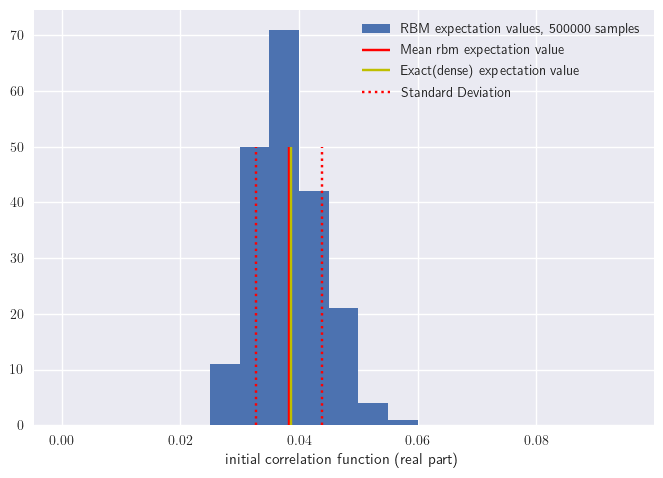

In [32]:
mean = np.mean(np.real(values))
bins = np.arange(0, 0.1, 0.005)
plt.hist(np.real(values), bins=bins,label = 'RBM expectation values, 500000 samples')
#plt.vlines(e[0], 0, 1100, color = 'r', label = 'Exact expectation value')
plt.vlines(np.mean(np.real(values)), 0, 50, color = 'r', label = 'Mean rbm expectation value')
plt.vlines(np.real(dense_exact), 0, 50, color = 'y', label = 'Exact(dense) expectation value')
plt.vlines(mean + np.std(values, ddof=1), 0, 50, color = 'r', linestyle = 'dotted', label = 'Standard Deviation')
plt.vlines(mean - np.std(values, ddof=1), 0, 50, color = 'r', linestyle = 'dotted')
plt.xlabel('initial correlation function (real part)')
plt.legend()
plt.show()